In [5]:
%reload_ext autoreload
%autoreload 2

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm_notebook

T = torch.from_numpy
TD = TensorDataset
DL = DataLoader

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [105]:
from sklearn.decomposition import PCA

import sys
sys.path.append('/home/yangz2/projects/bishop1995_notes/modules_for_nn_training')
from learner import Learner
from callbacks import CallbackHandler
from utility_callbacks import LossCallback, MulticlassAccuracyCallback, BinaryAccuracyCallback

from trainer import Trainer

In [110]:
confmats = []
for num_components in tqdm_notebook([2, 4, 6, 8, 10, 15, 20, 30, 40, 50]):
    
    with open(f'kia_gmvae_{num_components}_10000.json', 'r') as json_f:
        x = np.array(json.load(json_f))
        x = np.eye(len(np.unique(x)))[x]
        x = x.reshape(-1, 7 * 16 * 16)
        
    x = PCA(0.95, whiten=True).fit_transform(x)
    
    if num_components < 30:
        y = np.repeat(np.arange(num_components), 10000 // num_components)
    else:
        y = np.repeat(np.arange(num_components), 25000 // num_components)

    seed = np.random.randint(1000)
    np.random.seed(seed)
    np.random.shuffle(x)
    np.random.seed(seed)
    np.random.shuffle(y)
    
    x_train, y_train = x[:300 * num_components], y[:300 * num_components]
    x_valid, y_valid = x[-200 * num_components:], y[-200 * num_components:]

    train_ds = TD(T(x_train), T(y_train))
    train_dl = DL(train_ds, batch_size=64, shuffle=True)

    valid_ds = TD(T(x_valid), T(y_valid))
    valid_dl = DL(valid_ds, batch_size=64, shuffle=False)
    
    class NN(nn.Module):
    
        def __init__(self, num_classes, input_dim):
            super().__init__()

            self.num_classes = num_classes

            self.main = nn.Sequential(

                nn.Linear(input_dim, 500),
                nn.BatchNorm1d(500),  # maintain health gradient flow
                nn.ReLU(),

                nn.Linear(500, 500),
                nn.BatchNorm1d(500),  # maintain health gradient flow
                nn.ReLU(),

                nn.Linear(500, self.num_classes),  # maintain health gradient flow
                nn.ReLU(),

            )

        def forward(self, xb):
            xb = self.main(xb)
            return xb.view(-1, self.num_classes)
    
    def get_model(input_dim, num_classes):
        nn = NN(num_classes, input_dim)
        return nn, optim.Adam(nn.parameters(), lr=10)
    
    model, opt = get_model(input_dim=x.shape[1], num_classes=num_components)
    loss = nn.CrossEntropyLoss()
    learn = Learner(train_dl, valid_dl, model, loss, opt)

    loss_cb = LossCallback()
    acc_cb = MulticlassAccuracyCallback()
    cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

    trainer = Trainer(learn=learn, cb_handler=cb_handler)

    # trainer.find_lr(beta=0.98, final_value=100, num_itr=300)
    
    trainer.set_lr(5e-4)
    trainer.train(10)
    
    output = model(valid_ds.tensors[0].float())
    ypred = output.detach().numpy().argmax(axis=1)
    conf_mat = confusion_matrix(valid_ds.tensors[1].long().numpy(), ypred)
    
    confmats.append(conf_mat)

In [245]:
len(confmats)

10

In [246]:
num_components_s = [2, 4, 6, 8, 10, 15, 20, 30, 40, 50]
len(num_components_s)

10

In [253]:
accs_to_search = np.arange(70, 96, 5)
accs_s = [[] for k in accs_to_search]
for confmat in confmats:
    confmat = confmat / confmat.sum(axis=1).reshape(-1, 1)
    diag = confmat * np.eye(confmat.shape[0])
    for i, acc in enumerate(accs_to_search):
        accs_s[i].append(np.sum(diag[diag != 0] >= (acc / 100)))

In [254]:
np.array(accs_s).shape

(6, 10)

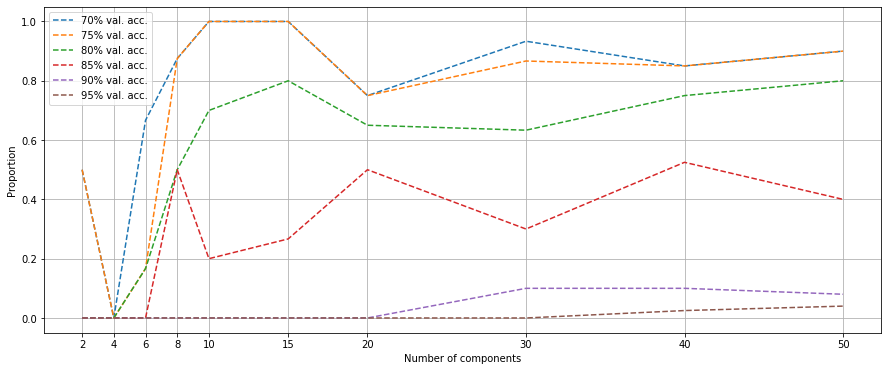

In [274]:
# plt.plot([0, 50], [0, 50])
plt.figure(figsize=(15, 6))
for i, (acc, accs) in enumerate(zip(accs_to_search, accs_s)):
    plt.plot(num_components_s, np.array(accs) / np.array(num_components_s), '--', label=f'{acc}% val. acc.')
plt.xlabel('Number of components'); plt.ylabel('Proportion')
plt.xticks(num_components_s)
plt.grid()
plt.legend()
plt.show()

In [97]:
np.array(num_components_s)

In [99]:
GAME = 'kia'

(9, 3, 1)

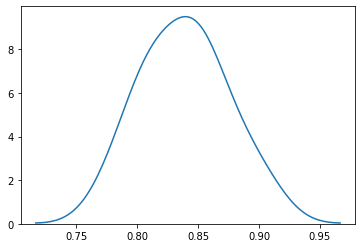

In [102]:
sns.kdeplot(diag[diag != 0])

In [60]:
component_array = np.array([2, 4, 6, 8, 10, 15, 20, 30, 40, 50])
num_acc_80_array = np.array([2, 0, 3, 7, 9, 12, 12, 19, 27, 36])
num_acc_85_array = np.array([0, 0, 1, 6, 5, 9, 5, 12, 16, 21])
num_acc_90_array = np.array([0, 0, 0, 1, 1, 2, 0, 2, 5, 11])

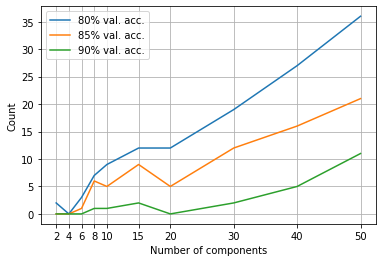

In [61]:
plt.plot(component_array, num_acc_80_array, label='80% val. acc.')
plt.plot(component_array, num_acc_85_array, label='85% val. acc.')
plt.plot(component_array, num_acc_90_array, label='90% val. acc.')
plt.xlabel('Number of components'); plt.ylabel('Count')
plt.xticks(component_array);# plt.yticks(np.arange(13))
plt.grid()
plt.legend()
plt.show()

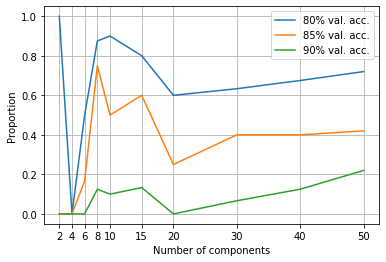

In [62]:
plt.plot(component_array, num_acc_80_array / component_array, label='80% val. acc.')
plt.plot(component_array, num_acc_85_array / component_array, label='85% val. acc.')
plt.plot(component_array, num_acc_90_array / component_array, label='90% val. acc.')
plt.xlabel('Number of components'); plt.ylabel('Proportion')
plt.xticks(component_array);# plt.yticks(np.arange(13))
plt.grid()
plt.legend()
plt.show()

In [140]:
# accs_by_component = []
# for num_component in [2, 4, 6, 8, 10, 15, 20]:
    
#     with open(f'kia_gmvae_{num_components}_10000.json', 'r') as json_f:
#         x = np.array(json.load(json_f))
#         x = np.eye(len(np.unique(x)))[x]
#         x = x.reshape(-1, 7 * 16 * 16)
        
#     y = np.repeat(np.arange(num_components), 10000 // num_components)
    
#     accs = []
    
#     for i in range(10):
    
#         seed = np.random.randint(10)
#         np.random.seed(seed)
#         np.random.shuffle(x)
#         np.random.seed(seed)
#         np.random.shuffle(y)

#         x_train, y_train = x[:300 * num_components], y[:300 * num_components]
#         x_valid, y_valid = x[-200 * num_components:], y[-200 * num_components:]

#         train_ds = TD(T(x_train), T(y_train))
#         train_dl = DL(train_ds, batch_size=64, shuffle=True)

#         valid_ds = TD(T(x_valid), T(y_valid))
#         valid_dl = DL(valid_ds, batch_size=64, shuffle=False)

#         model, opt = get_model(num_classes=num_components)
#         loss = nn.CrossEntropyLoss()
#         learn = Learner(train_dl, valid_dl, model, loss, opt)

#         loss_cb = LossCallback()
#         acc_cb = MulticlassAccuracyCallback()
#         cb_handler = CallbackHandler(cbs=[loss_cb, acc_cb])

#         trainer = Trainer(learn=learn, cb_handler=cb_handler)

#         trainer.set_lr(7e-4)
#         trainer.train(10)
    
#         accs.append(acc_cb.state_dict['accs'][-1])
        
#     accs_by_component.append(np.mean(accs))